In [115]:
import pandas as pd
import numpy as np
import time

#sklearn
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

#classifiers
from sklearn.svm import LinearSVC



#visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
%matplotlib inline

In [2]:
df_processed = pd.read_csv('data/loan_fteng_data_text.csv')

In [4]:
df_processed.shape

(39318, 69)

#### Reading in processed data

In [3]:
#columns in dataset
df_processed.columns

Index(['loan_amnt', 'funded_amnt_inv', 'home_ownership', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'revol_bal', 'loan_status', 'desc_senti_score',
       'bill', 'borrow', 'card', 'consolid', 'credit', 'current', 'debt',
       'fund', 'help', 'interest', 'job', 'loan', 'make', 'money', 'month',
       'need', 'one', 'pay', 'payment', 'plan', 'rate', 'thank', 'time',
       'work', 'year', 'per_act_open', 'grade_A', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'term_ 36 months',
       'term_ 60 months', 'emp_length', 'int_rate',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purp

In [7]:
#all features
all_features = list(df_processed.columns)

#### Feature Engineering

In [10]:
#columns to be deleted - simlar to loan amount
del_columns = ['funded_amnt_inv']

In [11]:
#Using intution to pick key predictors
predictors_intution = ['home_ownership','verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified','has_delinquent_hist','has_record_hist']

In [18]:
# % and whole numbers that can be standardized
predictors_standardizable = ['loan_amnt','per_act_open','inq_last_6mths','avg_fico','revol_util','revol_bal','dti','years_since_first_credit','int_rate','emp_length','desc_senti_score']

In [20]:
predictors_remaining = [i for i in all_features if i not in predictors_intution and i not in predictors_standardizable and i not in del_columns]

In [22]:
#validating if all columns are there
test = predictors_intution + predictors_standardizable + predictors_remaining
len(test)

68

In [76]:
#full_data

full_df = df_processed.loc[:,test]

#### Train/Test set 

In [28]:
#Creating train/test data
itrain, itest = train_test_split(np.arange(full_df.shape[0]), train_size=0.7)

In [29]:
#creating a mask to identify train/test records across different types of feature selection later.
mask=np.ones(full_df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [30]:
mask

array([False,  True,  True, ...,  True, False, False], dtype=bool)

#### Standardizing Features

In [77]:

for col in predictors_standardizable:
    print(col)
    valstrain=full_df.loc[mask,col]
    valstest=full_df.loc[~mask,col]
    scaler=StandardScaler().fit(valstrain.reshape(-1,1))
    outtrain=scaler.transform(valstrain.reshape(-1,1))
    outtest=scaler.fit_transform(valstest.reshape(-1,1))
    out=np.empty(mask.shape[0])
    out.flat[mask]=outtrain
    out.flat[~mask]=outtest
    full_df[col]=out


loan_amnt
per_act_open
inq_last_6mths
avg_fico
revol_util
revol_bal
dti
years_since_first_credit
int_rate
emp_length
desc_senti_score


/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [78]:
full_df.head(2)

,home_ownership,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,has_delinquent_hist,has_record_hist,loan_amnt,per_act_open,inq_last_6mths,avg_fico,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,bankruptcies
0,0,0,0,1,0,0,-0.821744,-0.734703,0.125685,0.545403,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,1,0,0,0,-1.171339,1.496181,3.840588,0.701983,...,0,0,0,0,0,0,0,0,0,0.0


In [79]:
predictor_columns = list(full_df.columns)
predictor_columns.remove('loan_status')
len(predictor_columns)

67

#### Exploratory Data Analysis


In [92]:
text_fields = ['bill', 'borrow', 'card', 'consolid', 'credit', 'current', 'debt',
       'fund', 'help', 'interest', 'job', 'loan', 'make', 'money', 'month',
       'need', 'one', 'pay', 'payment', 'plan', 'rate', 'thank', 'time',
       'work', 'year']

In [93]:
#KDE plot for exploring continuous variables and histogram for indicators - discrete variables
print(len(predictors_standardizable))

indicators = [col for col in predictor_columns if col not in predictors_standardizable and col not in text_fields]
len(indicators)

11


31

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


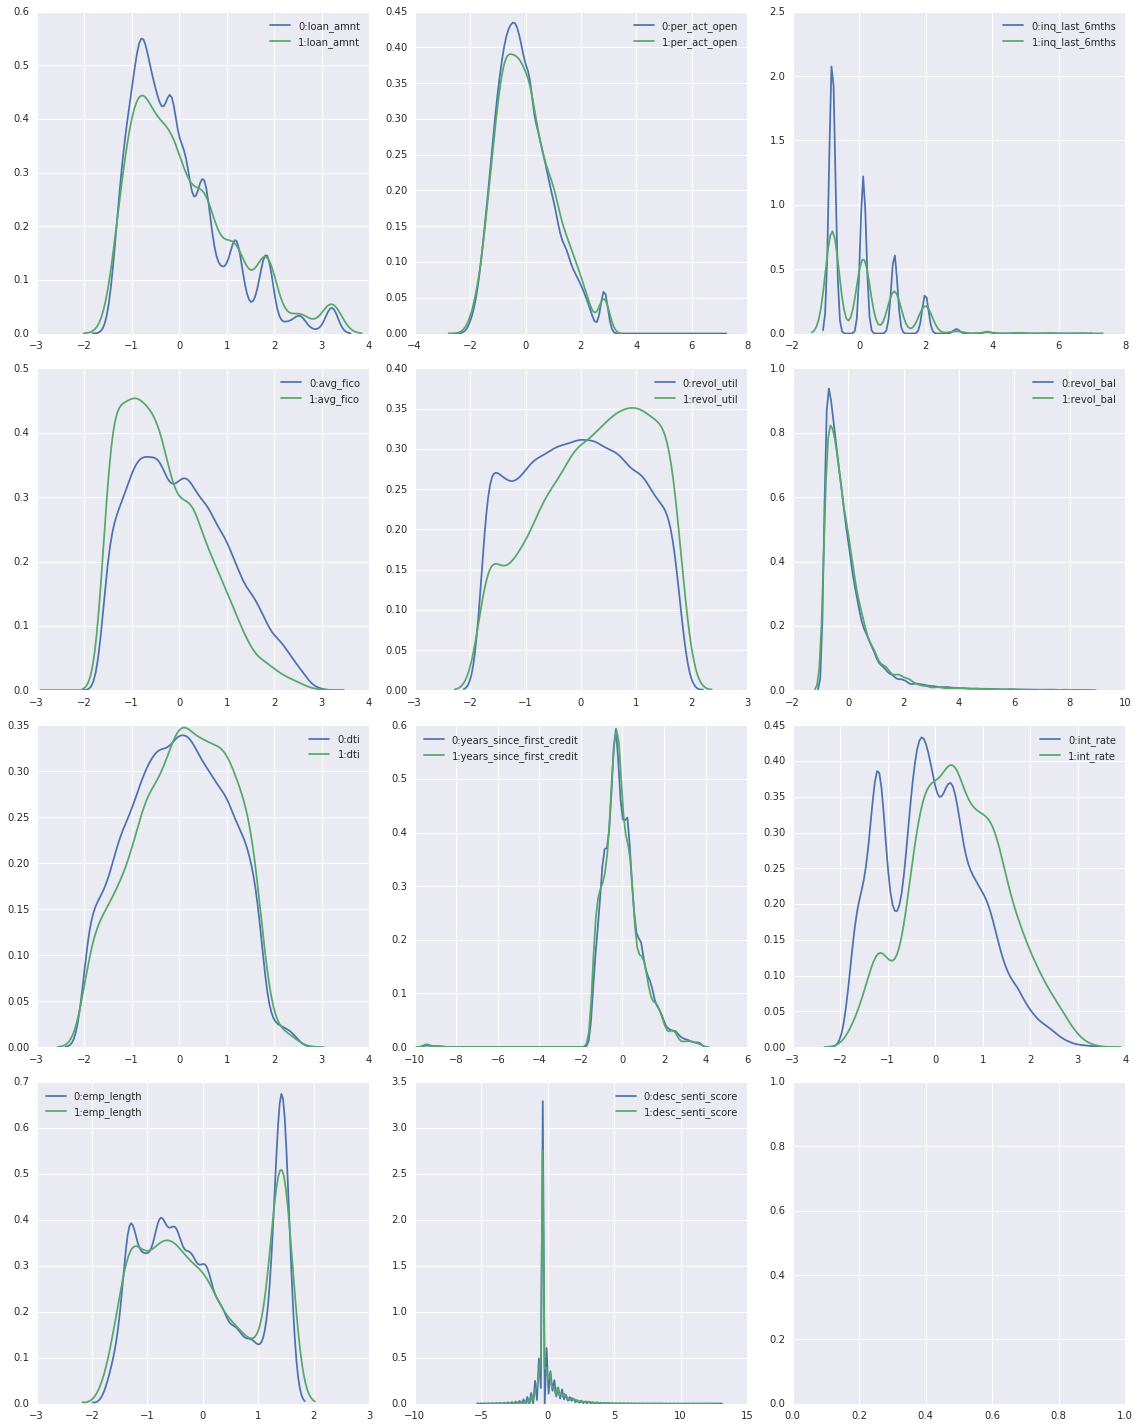

In [89]:
##### Kernel density estimate
#looking for features where the two line do not overlap much
df_grpby=full_df.groupby('loan_status')
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), predictors_standardizable):
    for k, v in df_grpby[p]:
        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name)

<b> Unfortuantely the standardized features all of them seam to overlap, none of them seem to be clear predictor<b>

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


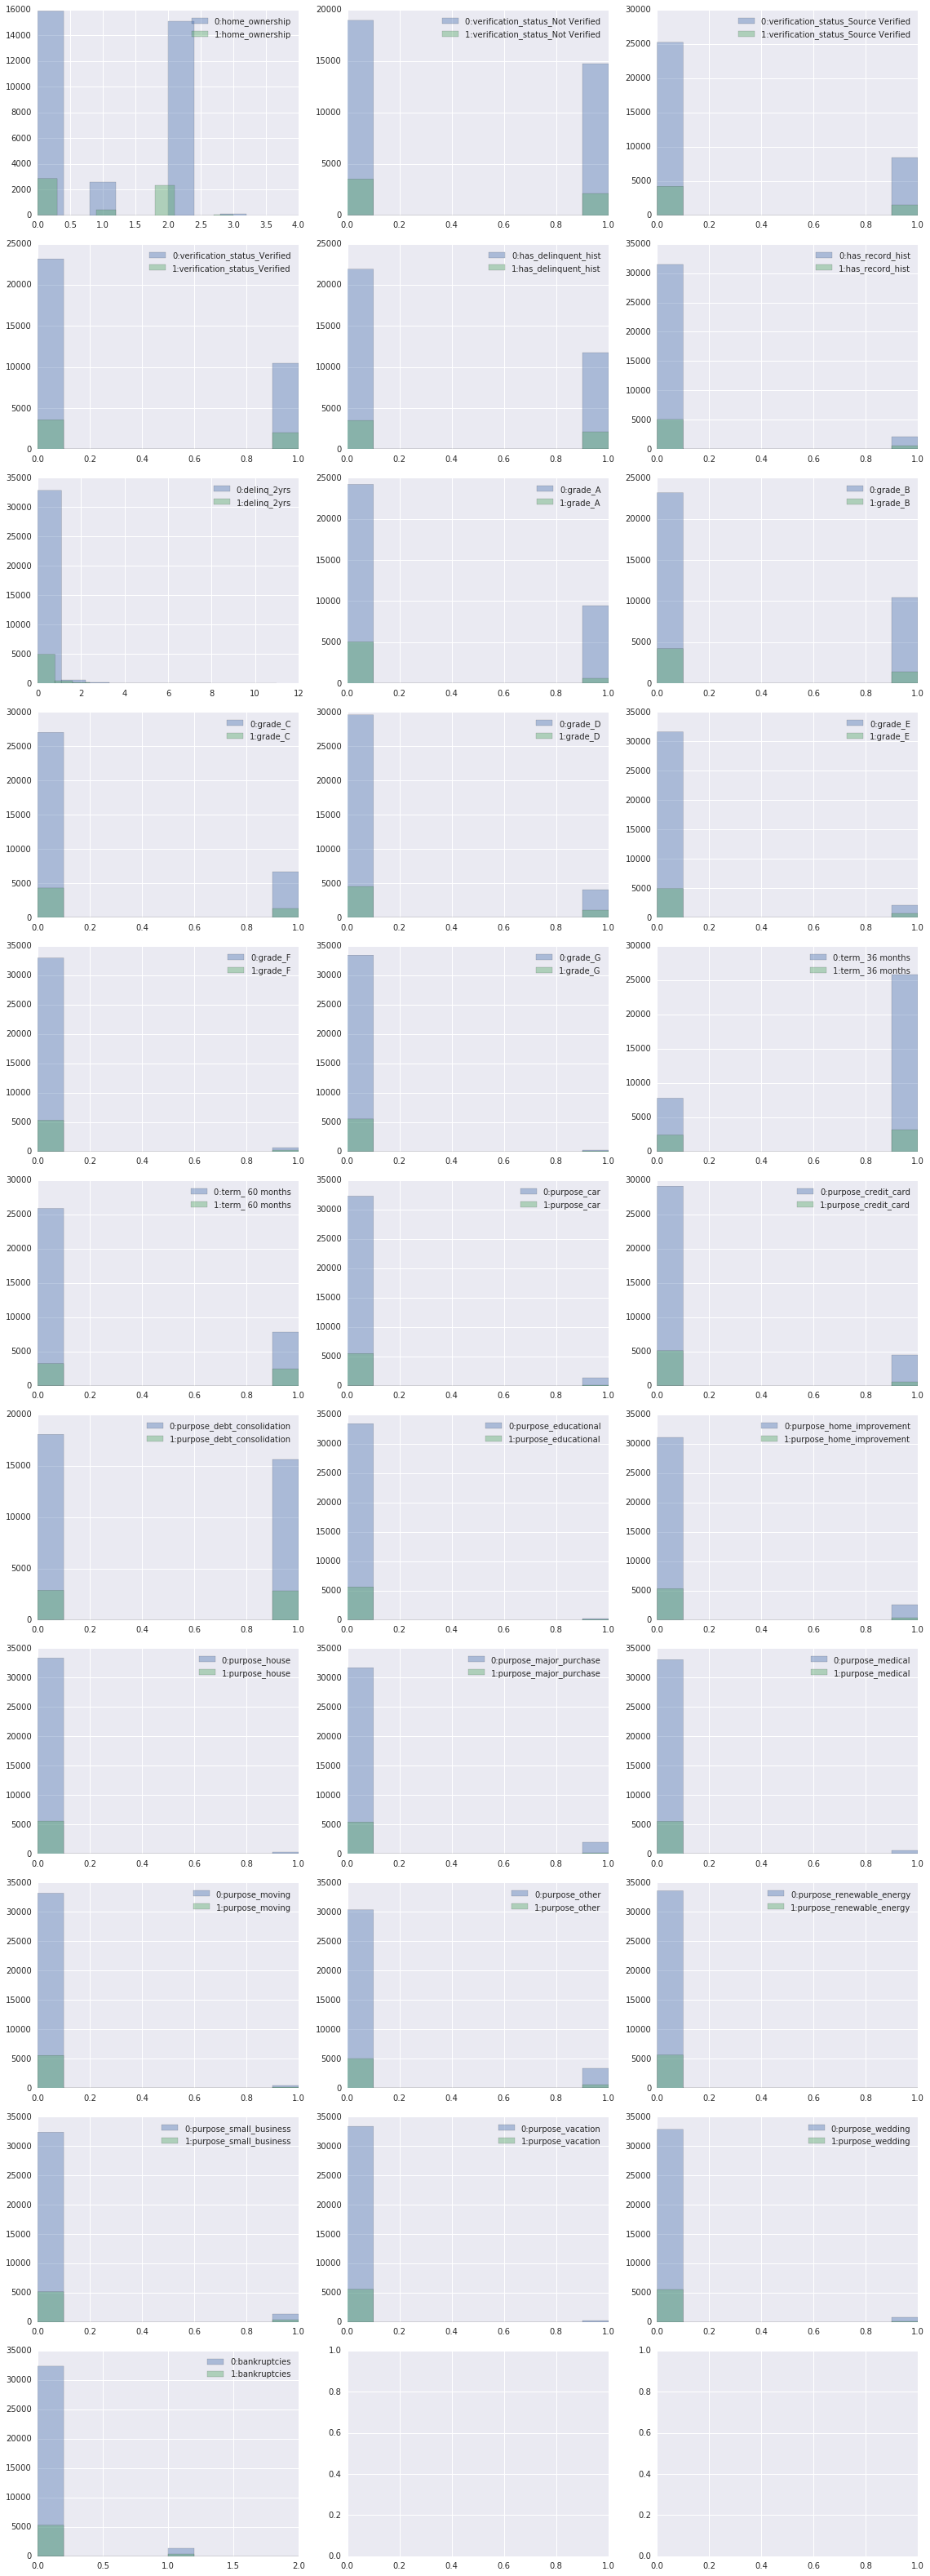

In [95]:
#histogram for indicator / discrete variables
#looking for bar which are exclusively belonging to one class
#your code here
df_grpby=full_df.groupby('loan_status')
fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(16, 44), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), indicators):
    for k, v in df_grpby[p]:
        v.hist(ax=ax, alpha=0.4, label=str(k)+":"+v.name)
        ax.legend()

<b>Homeownership and term of 36 months seem to be relatively strong predictors of bad loans<b>

### Running Classifiers

#### Linear SVM

In [98]:
clf_svm=LinearSVC(loss="hinge")
C=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
X =full_df[predictor_columns]
Y =full_df['loan_status']

In [99]:
X_train=X[mask]
X_test=X[~mask]
Y_train=Y[mask]
Y_test=Y[~mask]

In [101]:

gs=GridSearchCV(clf_svm, param_grid={'C':C}, cv=5)
gs.fit(X_train, Y_train)
print("BEST", gs.best_params_, gs.best_score_, gs.grid_scores_)

BEST {'C': 0.001} 0.856587457307 [mean: 0.85659, std: 0.00008, params: {'C': 0.001}, mean: 0.85659, std: 0.00008, params: {'C': 0.01}, mean: 0.85659, std: 0.00008, params: {'C': 0.1}, mean: 0.85659, std: 0.00008, params: {'C': 1.0}, mean: 0.85659, std: 0.00008, params: {'C': 10.0}, mean: 0.83061, std: 0.01608, params: {'C': 100.0}]


/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [102]:
#accuracy
best = gs.best_estimator_
best.fit(X_train, Y_train)
best.score(X_test, Y_test)

0.85520515428958965

In [117]:

'''

   Input
   -----
   X: Training Features
   Y_bin: Values Predicted binarized
   classifier_name: Name of classifier
   classifier: sklearn classifier init
   param_dict: dictionary of parameters to be passed to classifier
   scor_func: scoring method used
   no_cv: # of cvv
   
   Output
   ------
   training_time: training time in minutes
   best_estimator: best model after cvv
   best_params: best parameter 
   best_score: best score
   
'''

def perform_classify(X,Y,mask,classifier_name,classifier,param_dict,scor_func,no_cv):
    #training start time
    start_time = time.clock()
    clf = classifier
    parameters = param_dict
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=no_cv, scoring=scor_func)
    
    X_train, X_test, y_train, y_test = X[mask], X[~mask], Y[mask], Y[~mask]
    fitmodel.fit(X_train,y_train)
    

    
    best_estimator = fitmodel.best_estimator_
    best_params = fitmodel.best_params_
    best_score = fitmodel.best_score_
    
    end_time = time.clock()
    training_time = (end_time - start_time)/60.0
    
    training_accuracy = best_estimator.score(X_train, y_train)
    test_accuracy = best_estimator.score(X_test, y_test)
    print("-------------- based on standard predict -----------------")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(y_test, best_estimator.predict(X_test)))
    print("-----------------------------------------------------------")
    
    print('{} Training Time : {} minutes'.format(classifier_name,training_time))
    print('{} Best Estimator \n {}'.format(classifier_name,best_estimator))
    print('{} Best Params \n {}'.format(classifier_name,best_params))
    print('{} Best {} \n {}'.format(classifier_name,scor_func,best_score))##, fitmodel.grid_scores_
    
    
    return training_time,best_estimator,best_params,best_score
  

In [108]:
#parameters passed for Linear SVM
classifier_name = 'Linear SVM'
classifier = LinearSVC(loss="hinge")
param_dict = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
no_cv = 5
scor_func = 'accuracy'

In [118]:
#calling classifier on training set
lsvm_training_time,lsvm_best_estimator,lsvm_best_params,lsvm_best_score = perform_classify(X,Y,mask,classifier_name,classifier,param_dict,scor_func,no_cv)

-------------- based on standard predict -----------------
Accuracy on training data: 0.86
Accuracy on test data:     0.86
[[10088     0]
 [ 1708     0]]
-----------------------------------------------------------
Linear SVM Training Time : 1.1170833999999998 minutes
Linear SVM Best Estimator 
 LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
Linear SVM Best Params 
 {'C': 0.001}
Linear SVM Best accuracy 
 0.8565874573068818


### Esimating Costs

In [122]:
np.sum(~mask)

11796

In [119]:
#checking symmetry of data
1-Y.mean()

0.8561727453074928

<b> Data is highly assymetric, just predicting all loans as good will give an accuracy of 86%. Also linear SVM is not better than just predicting all as good loans will also give an accuracy of ~86% <b>

In [104]:
1-Y.mean()

0.8561727453074928

#### Determining Costs associated with TN, FN, FP, TP

<img src='images/confusionmatrix.png'></img>

In [125]:
#
confusion_matrix(Y_test, lsvm_best_estimator.predict(X_test))

array([[10088,     0],
       [ 1708,     0]])

<b>Our primary objective will be to maximize TP, therefore minizming FN. As FN would impact the lenders and they could potentially loose their investment</b>

#### True Negative

<b> TN (True Negative) are the good loans. The lenders only stand to gain from them. loss is 0 and gain corresponds to the interest  <b>

In [126]:
data_raw = pd.read_csv("data/loan_2007_2011.csv")

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [147]:
data_raw = data_raw.loc[data_raw.loan_status.isin(['Charged Off','Fully Paid']),:]

In [161]:
#computing true negative cost =  average interest gain per loan
tnc = -round(np.mean(data_raw.total_rec_int),0)
tnc

-2207.0

In [178]:
#computing false negative score = minus of average interest gain per loan
fnc = round(np.sum(data_raw.funded_amnt_inv - data_raw.total_rec_prncp)/Y.sum(),0)
fnc

3899.0

In [163]:
#computing true postive score = avg total principal that was lost + loss of interest

tpc = -round(np.sum(data_raw.funded_amnt_inv - data_raw.total_rec_prncp)/Y.sum(),0)

tpc

-3899.0

In [180]:
#computing false positive score, nothing gained
fpc = 0
fpc

0

In [181]:
#risk matrix
risk_matrix=np.array([[tnc, fpc],[fnc, tpc]])
risk_matrix

array([[-2207.,     0.],
       [ 3899., -3899.]])

In [182]:
#profit matrix
u = -risk_matrix
u

array([[ 2207.,    -0.],
       [-3899.,  3899.]])